In [1]:
import mne
import fooof
import numpy as np
import os.path as op
import pickle
import saflow
import saflow
import os.path as op
import pickle as pkl
import numpy as np
import pandas as pd
import os
import mne_bids
import mne
from sklearn.model_selection import permutation_test_score, LeaveOneGroupOut
from sklearn.pipeline import Pipeline
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.preprocessing import StandardScaler
from scipy import stats
import matplotlib.pyplot as plt
import fooof
from statsmodels.stats.multitest import fdrcorrection
import random
from matplotlib.backends.backend_pdf import PdfPages
from saflow.utils import create_fnames, get_meg_picks_and_info
from saflow.neuro import average_bands
from saflow.data import balance_data, load_fooof_data, load_subjlevel_fooofs
from saflow.visualization import grid_topoplot
from saflow.stats import singlefeat_classif, simple_contrast, mask_pvals, apply_tmax, subject_contrast
import os



/tmp/ipykernel_24770/688341328.py:2: DeprecationWarning: 
The `fooof` package is being deprecated and replaced by the `specparam` (spectral parameterization) package.
This version of `fooof` (1.1) is fully functional, but will not be further updated.
New projects are recommended to update to using `specparam` (see Changelog for details).
  import fooof


In [2]:
# Load subject-level fooofs


## PSD uncorrected

In [3]:
# Load data
## TRIAL-LEVEL
feature = 'fooof_1022_knee_sensor_8trials'
feature_fpath = op.join(saflow.BIDS_PATH, 'derivatives', feature)
feat_to_get = 'psd_raw'
classif = 'INOUT_2575'
trial_type_to_get = ['correct_commission']
trial_type_formatted = '-'.join(trial_type_to_get)
classif_name_data = f'{classif}_{feature}_{feat_to_get}_{trial_type_formatted}'

alpha = 0.05
n_perms = 1000


loaded_data_filename = f'../tmp/{classif_name_data}.pkl'
if not op.exists(loaded_data_filename):
    X, y, groups, VTC, task = load_fooof_data(feature, feature_fpath, feat_to_get, trial_type_to_get, classif=classif)
    with open(loaded_data_filename, 'wb') as f:
        pkl.dump([X, y, groups, VTC, task], f)
else:
    with open(loaded_data_filename, 'rb') as f:
        X, y, groups, VTC, task = pkl.load(f)
        
X_bal, y_bal, gr_bal = balance_data(X,y,groups)
print(f'Data shape before balance : {X.shape} and after balance : {X_bal.shape}')


# Classif SF
picks, chan_info = get_meg_picks_and_info('12', '02')
classif_name = f'lda_{classif}_{feature}_{feat_to_get}_{trial_type_formatted}_{n_perms}perms'
output_filename = f'../tmp/{classif_name}.pkl'

if not op.exists(output_filename):
    all_results = singlefeat_classif(LinearDiscriminantAnalysis(), LeaveOneGroupOut(), X_bal, y_bal, gr_bal, n_perms=n_perms)
    with open(output_filename, 'wb') as f:
        pkl.dump(all_results, f)
else:
    with open(output_filename, 'rb') as f:
        all_results = pkl.load(f)

# Plot results


picks, chan_info = get_meg_picks_and_info('12', '02')

X_raw, X_corrected, X_model, X_ksor, y_subjlevel, groups_subjlevel = load_subjlevel_fooofs(feature, feature_fpath)
X_contrast, tvals, pvals = simple_contrast(X_bal, y_bal, gr_bal)
#X_contrast, tvals, pvals = subject_contrast(X_raw, y_subjlevel)
qvals = np.array([fdrcorrection(pvals[x,:])[1] for x in range(pvals.shape[0])])
pvals_masks = np.array([mask_pvals(pvals[x,:], alpha) for x in range(pvals.shape[0])])
tmax_pvals = apply_tmax(all_results)
tmax_pvals_masks = np.array([mask_pvals(tmax_pvals[x,:], alpha) for x in range(tmax_pvals.shape[0])])
masks = np.array([np.zeros_like(pvals_masks), pvals_masks, tmax_pvals_masks])

titles_x = ['Delta (2-4Hz)', 'Theta (4-8Hz)', 'Alpha (8-12Hz)', 
            'Low Beta (12-20Hz)', 'High Beta (20-30Hz)',
            'Gamma 1 (30-60Hz)', 'Gamma 2 (60-90Hz)', 'Gamma 3 (90-120Hz)']
titles_y = ['Diff', 'T-values', 'LDA accuracy']
cmap = ['coolwarm', 'coolwarm', 'magma']
maxval_contrast = np.max(abs(X_contrast))
maxval_tvals = np.max(abs(tvals))
vlims = [(-maxval_contrast,maxval_contrast), (-maxval_tvals,maxval_tvals), (0.5,np.max(all_results['scores']))]
fig, axes = grid_topoplot(np.array([X_contrast, tvals, all_results['scores']]), 
                          chan_info, 
                          titles_x=titles_x, titles_y=titles_y, 
                          masks=masks, 
                          cmap=cmap, 
                          vlims=vlims, 
                          title=f'{classif_name}_{alpha}')

Subject sub-04 max trials : 36 OUT
36 113
36
Subject sub-05 max trials : 154 IN
154 187
154
Subject sub-06 max trials : 60 OUT
60 93
60
Subject sub-07 max trials : 148 OUT
148 194
148
Subject sub-08 max trials : 30 OUT
40 30
30
Subject sub-09 max trials : 153 IN
180 153
153
Subject sub-10 max trials : 200 IN
200 235
200
Subject sub-11 max trials : 110 OUT
110 159
110
Subject sub-12 max trials : 169 OUT
169 255
169
Subject sub-13 max trials : 139 IN
139 202
139
Subject sub-14 max trials : 216 IN
216 219
216
Subject sub-15 max trials : 9 IN
24 9
9
Subject sub-17 max trials : 215 OUT
215 252
215
Subject sub-18 max trials : 25 OUT
25 54
25
Subject sub-20 max trials : 114 OUT
114 187
114
Subject sub-21 max trials : 317 OUT
321 317
317
Subject sub-22 max trials : 127 OUT
127 233
127
Subject sub-23 max trials : 11 OUT
72 11
11
Subject sub-24 max trials : 114 IN
114 200
114
Subject sub-26 max trials : 251 IN
251 251
251
Subject sub-28 max trials : 258 IN
258 321
258
Subject sub-29 max trials :

In [ ]:
# Load data
## SUBJECT-LEVEL
feature = 'fooof_1022_knee_sensor_8trials'
feature_fpath = op.join(saflow.BIDS_PATH, 'derivatives', feature)
feat_to_get = 'psd_raw'
classif = 'INOUT_2575'
trial_type_to_get = ['correct_commission']
trial_type_formatted = '-'.join(trial_type_to_get)

alpha = 0.05
n_perms = 1000

classif_name_data = f'{classif}_{feature}_{feat_to_get}_{trial_type_formatted}'


X_raw, X_corrected, X_model, X_ksor, y_subjlevel, groups_subjlevel = load_subjlevel_fooofs(feature, feature_fpath)

X_contrast, tvals, pvals = subject_contrast(X_raw, y_subjlevel)

# Classif SF
picks, chan_info = get_meg_picks_and_info('12', '02')
classif_name = f'lda_{classif}_{feature}_{feat_to_get}_{trial_type_formatted}_{n_perms}perms_subjlevel'
output_filename = f'../tmp/{classif_name}.pkl'

if not op.exists(output_filename):
    all_results = singlefeat_classif(LinearDiscriminantAnalysis(), LeaveOneGroupOut(), X_raw, y_subjlevel, groups_subjlevel, n_perms=n_perms)
    with open(output_filename, 'wb') as f:
        pkl.dump(all_results, f)
else:
    with open(output_filename, 'rb') as f:
        all_results = pkl.load(f)

# Plot results
picks, chan_info = get_meg_picks_and_info('12', '02')

qvals = np.array([fdrcorrection(pvals[x,:])[1] for x in range(pvals.shape[0])])
pvals_masks = np.array([mask_pvals(pvals[x,:], alpha) for x in range(pvals.shape[0])])
tmax_pvals = apply_tmax(all_results)
tmax_pvals_masks = np.array([mask_pvals(tmax_pvals[x,:], alpha) for x in range(tmax_pvals.shape[0])])
masks = np.array([np.zeros_like(pvals_masks), pvals_masks, tmax_pvals_masks])

titles_x = ['Delta (2-4Hz)', 'Theta (4-8Hz)', 'Alpha (8-12Hz)', 
            'Low Beta (12-20Hz)', 'High Beta (20-30Hz)',
            'Gamma 1 (30-60Hz)', 'Gamma 2 (60-90Hz)', 'Gamma 3 (90-120Hz)']
titles_y = ['Diff', 'T-values', 'LDA accuracy']
cmap = ['coolwarm', 'coolwarm', 'magma']
maxval_contrast = np.max(abs(X_contrast))
maxval_tvals = np.max(abs(tvals))
vlims = [(-maxval_contrast,maxval_contrast), (-maxval_tvals,maxval_tvals), (0.5,np.max(all_results['scores']))]
fig, axes = grid_topoplot(np.array([X_contrast, tvals, all_results['scores']]), 
                          chan_info, 
                          titles_x=titles_x, titles_y=titles_y, 
                          masks=masks, 
                          cmap=cmap, 
                          vlims=vlims, 
                          title=f'{classif_name}_{alpha}')

(270, 8)


ZeroDivisionError: division by zero

## PSD slope corrected

Subject sub-04 max trials : 36 OUT
36 113
36
Subject sub-05 max trials : 154 IN
154 187
154
Subject sub-06 max trials : 60 OUT
60 93
60
Subject sub-07 max trials : 148 OUT
148 194
148
Subject sub-08 max trials : 30 OUT
40 30
30
Subject sub-09 max trials : 153 IN
180 153
153
Subject sub-10 max trials : 148 OUT
148 235
148
Subject sub-11 max trials : 110 OUT
110 159
110
Subject sub-12 max trials : 169 OUT
169 255
169
Subject sub-13 max trials : 139 IN
139 202
139
Subject sub-14 max trials : 216 IN
216 219
216
Subject sub-15 max trials : 9 IN
24 9
9
Subject sub-17 max trials : 215 OUT
215 252
215
Subject sub-18 max trials : 25 OUT
25 54
25
Subject sub-20 max trials : 114 OUT
114 187
114
Subject sub-21 max trials : 317 OUT
321 317
317
Subject sub-22 max trials : 127 OUT
127 233
127
Subject sub-23 max trials : 11 OUT
72 11
11
Subject sub-24 max trials : 114 IN
114 200
114
Subject sub-26 max trials : 251 IN
251 251
251
Subject sub-28 max trials : 258 IN
258 321
258
Subject sub-29 max trials 

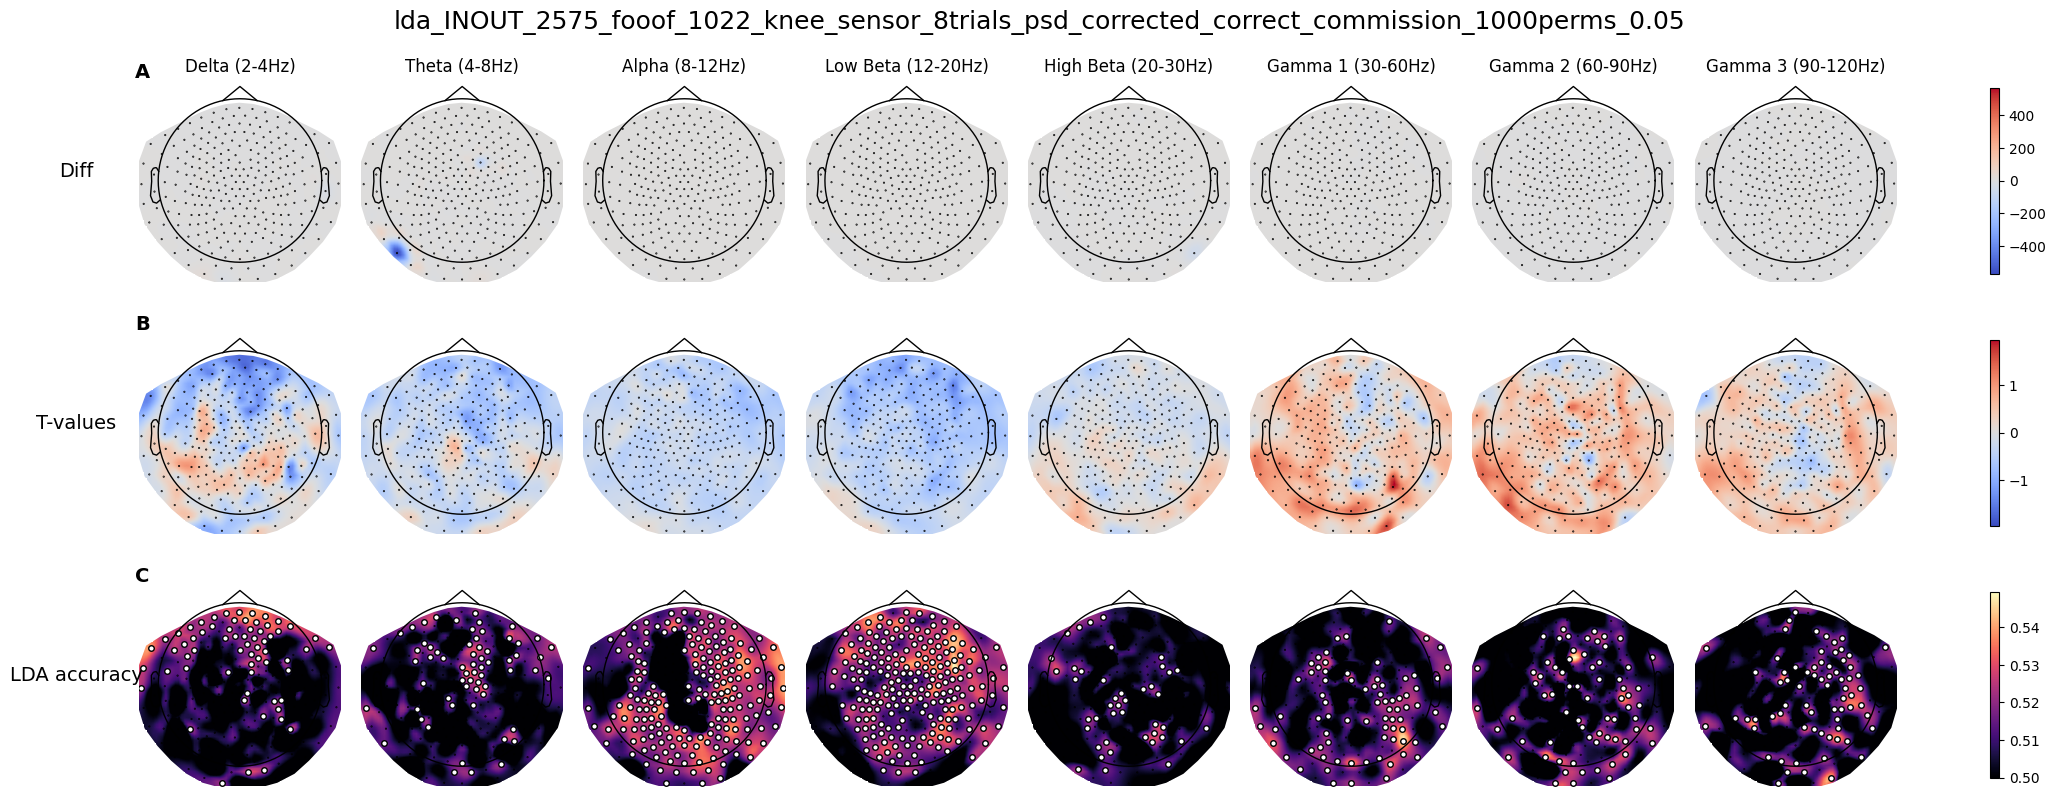

In [5]:
# Load data
## TRIAL-LEVEL
feature = 'fooof_1022_knee_sensor_8trials'
feat_to_get = 'psd_corrected'
classif = 'INOUT_2575'
trial_type_to_get = ['correct_commission']
trial_type_formatted = '-'.join(trial_type_to_get)

alpha = 0.05
n_perms = 1000

classif_name_data = f'{classif}_{feature}_{feat_to_get}_{trial_type_formatted}'

loaded_data_filename = f'../tmp/{classif_name_data}.pkl'
if not op.exists(loaded_data_filename):
    feature_fpath = op.join(saflow.BIDS_PATH, 'derivatives', feature)
    X, y, groups, VTC, task = load_fooof_data(feature, feature_fpath, feat_to_get, trial_type_to_get, classif=classif)
    with open(loaded_data_filename, 'wb') as f:
        pkl.dump([X, y, groups, VTC, task], f)
else:
    with open(loaded_data_filename, 'rb') as f:
        X, y, groups, VTC, task = pkl.load(f)
        
X_bal, y_bal, gr_bal = balance_data(X,y,groups)
print(f'Data shape before balance : {X.shape} and after balance : {X_bal.shape}')


# Classif SF

picks, chan_info = get_meg_picks_and_info('12', '02')
classif_name = f'lda_{classif}_{feature}_{feat_to_get}_{trial_type_formatted}_{n_perms}perms'
output_filename = f'../tmp/{classif_name}.pkl'

if not op.exists(output_filename):
    all_results = singlefeat_classif(LinearDiscriminantAnalysis(), LeaveOneGroupOut(), X_bal, y_bal, gr_bal, n_perms=n_perms)
    with open(output_filename, 'wb') as f:
        pkl.dump(all_results, f)
else:
    with open(output_filename, 'rb') as f:
        all_results = pkl.load(f)


X_raw, X_corrected, X_model, X_ksor, y_subjlevel, groups_subjlevel = load_subjlevel_fooofs(feature, feature_fpath)
X_contrast, tvals, pvals = simple_contrast(X_bal, y_bal, gr_bal)
#X_contrast, tvals, pvals = subject_contrast(X_raw, y_subjlevel)
qvals = np.array([fdrcorrection(pvals[x,:])[1] for x in range(pvals.shape[0])])
pvals_masks = np.array([mask_pvals(pvals[x,:], alpha) for x in range(pvals.shape[0])])
tmax_pvals = apply_tmax(all_results)
tmax_pvals_masks = np.array([mask_pvals(tmax_pvals[x,:], alpha) for x in range(tmax_pvals.shape[0])])
masks = np.array([np.zeros_like(pvals_masks), pvals_masks, tmax_pvals_masks])

titles_x = ['Delta (2-4Hz)', 'Theta (4-8Hz)', 'Alpha (8-12Hz)', 
            'Low Beta (12-20Hz)', 'High Beta (20-30Hz)',
            'Gamma 1 (30-60Hz)', 'Gamma 2 (60-90Hz)', 'Gamma 3 (90-120Hz)']
titles_y = ['Diff', 'T-values', 'LDA accuracy']
cmap = ['coolwarm', 'coolwarm', 'magma']
maxval_contrast = np.max(abs(X_contrast))
maxval_tvals = np.max(abs(tvals))
vlims = [(-maxval_contrast,maxval_contrast), (-maxval_tvals,maxval_tvals), (0.5,np.max(all_results['scores']))]
fig, axes = grid_topoplot(np.array([X_contrast, tvals, all_results['scores']]), 
                          chan_info, 
                          titles_x=titles_x, titles_y=titles_y, 
                          masks=masks, 
                          cmap=cmap, 
                          vlims=vlims, 
                          title=f'{classif_name}_{alpha}')

Subject sub-04 max trials : 36 OUT
36 113
36
Subject sub-05 max trials : 154 IN
154 187
154
Subject sub-06 max trials : 60 OUT
60 93
60
Subject sub-07 max trials : 148 OUT
148 194
148
Subject sub-08 max trials : 30 OUT
40 30
30
Subject sub-09 max trials : 153 IN
180 153
153
Subject sub-10 max trials : 148 OUT
148 235
148
Subject sub-11 max trials : 110 OUT
110 159
110
Subject sub-12 max trials : 169 OUT
169 255
169
Subject sub-13 max trials : 139 IN
139 202
139
Subject sub-14 max trials : 216 IN
216 219
216
Subject sub-15 max trials : 9 IN
24 9
9
Subject sub-17 max trials : 215 OUT
215 252
215
Subject sub-18 max trials : 25 OUT
25 54
25
Subject sub-20 max trials : 114 OUT
114 187
114
Subject sub-21 max trials : 317 OUT
321 317
317
Subject sub-22 max trials : 127 OUT
127 233
127
Subject sub-23 max trials : 11 OUT
72 11
11
Subject sub-24 max trials : 114 IN
114 200
114
Subject sub-26 max trials : 251 IN
251 251
251
Subject sub-28 max trials : 258 IN
258 321
258
Subject sub-29 max trials 

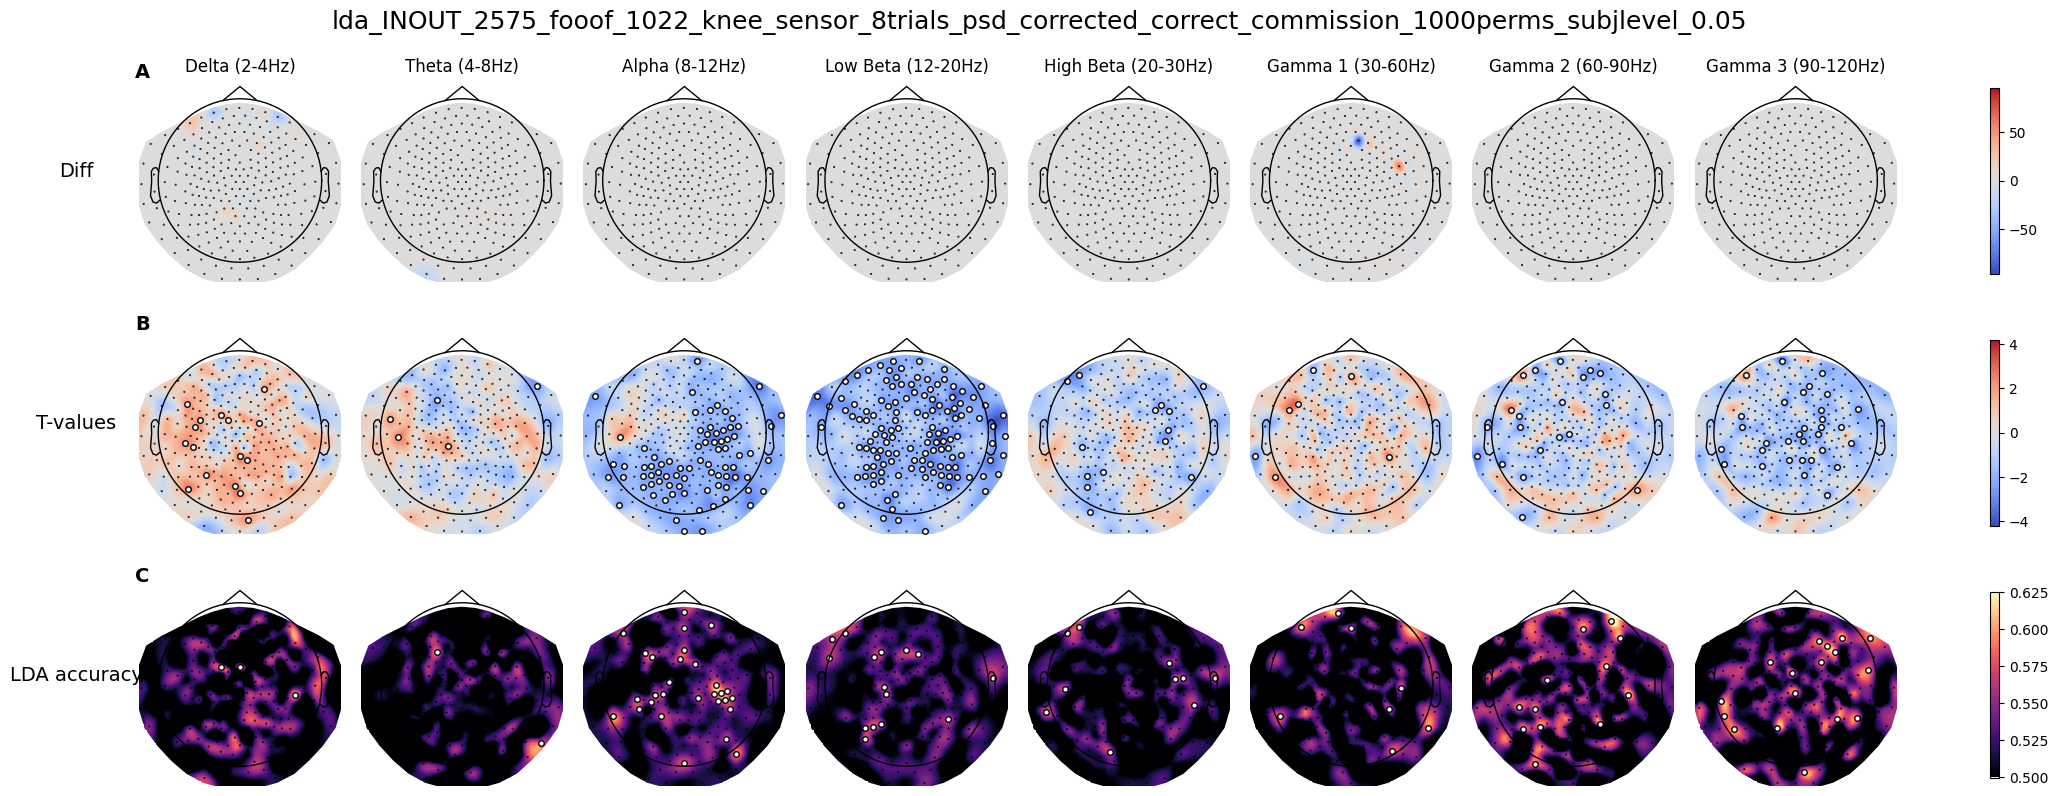

In [6]:
# Load data
## SUBJECT-LEVEL
feature = 'fooof_1022_knee_sensor_8trials'
feat_to_get = 'psd_corrected'
classif = 'INOUT_2575'
trial_type_to_get = ['correct_commission']
trial_type_formatted = '-'.join(trial_type_to_get)

alpha = 0.05
n_perms = 1000

classif_name_data = f'{classif}_{feature}_{feat_to_get}_{trial_type_formatted}'

loaded_data_filename = f'../tmp/{classif_name_data}.pkl'
if not op.exists(loaded_data_filename):
    feature_fpath = op.join(saflow.BIDS_PATH, 'derivatives', feature)
    X, y, groups, VTC, task = load_fooof_data(feature, feature_fpath, feat_to_get, trial_type_to_get, classif=classif)
    with open(loaded_data_filename, 'wb') as f:
        pkl.dump([X, y, groups, VTC, task], f)
else:
    with open(loaded_data_filename, 'rb') as f:
        X, y, groups, VTC, task = pkl.load(f)
        
X_bal, y_bal, gr_bal = balance_data(X,y,groups)
print(f'Data shape before balance : {X.shape} and after balance : {X_bal.shape}')
X_raw, X_corrected, X_model, X_ksor, y_subjlevel, groups_subjlevel = load_subjlevel_fooofs(feature, feature_fpath)
#X_contrast, tvals, pvals = simple_contrast(X_bal, y_bal, gr_bal)
X_contrast, tvals, pvals = subject_contrast(X_corrected, y_subjlevel)

# Classif SF
picks, chan_info = get_meg_picks_and_info('12', '02')
classif_name = f'lda_{classif}_{feature}_{feat_to_get}_{trial_type_formatted}_{n_perms}perms_subjlevel'
output_filename = f'../tmp/{classif_name}.pkl'

if not op.exists(output_filename):
    all_results = singlefeat_classif(LinearDiscriminantAnalysis(), LeaveOneGroupOut(), X_corrected, y_subjlevel, groups_subjlevel, n_perms=n_perms)
    with open(output_filename, 'wb') as f:
        pkl.dump(all_results, f)
else:
    with open(output_filename, 'rb') as f:
        all_results = pkl.load(f)


qvals = np.array([fdrcorrection(pvals[x,:])[1] for x in range(pvals.shape[0])])
pvals_masks = np.array([mask_pvals(pvals[x,:], alpha) for x in range(pvals.shape[0])])
tmax_pvals = apply_tmax(all_results)
tmax_pvals_masks = np.array([mask_pvals(tmax_pvals[x,:], alpha) for x in range(tmax_pvals.shape[0])])
masks = np.array([np.zeros_like(pvals_masks), pvals_masks, tmax_pvals_masks])

titles_x = ['Delta (2-4Hz)', 'Theta (4-8Hz)', 'Alpha (8-12Hz)', 
            'Low Beta (12-20Hz)', 'High Beta (20-30Hz)',
            'Gamma 1 (30-60Hz)', 'Gamma 2 (60-90Hz)', 'Gamma 3 (90-120Hz)']
titles_y = ['Diff', 'T-values', 'LDA accuracy']
cmap = ['coolwarm', 'coolwarm', 'magma']
maxval_contrast = np.max(abs(X_contrast))
maxval_tvals = np.max(abs(tvals))
vlims = [(-maxval_contrast,maxval_contrast), (-maxval_tvals,maxval_tvals), (0.5,np.max(all_results['scores']))]
fig, axes = grid_topoplot(np.array([X_contrast, tvals, all_results['scores']]), 
                          chan_info, 
                          titles_x=titles_x, titles_y=titles_y, 
                          masks=masks, 
                          cmap=cmap, 
                          vlims=vlims, 
                          title=f'{classif_name}_{alpha}')

## PSD model fit

Subject sub-04 max trials : 36 OUT
36 113
36
Subject sub-05 max trials : 154 IN
154 187
154
Subject sub-06 max trials : 60 OUT
60 93
60
Subject sub-07 max trials : 146 OUT
146 193
146
Subject sub-08 max trials : 30 OUT
38 30
30
Subject sub-09 max trials : 144 IN
178 144
144
Subject sub-10 max trials : 153 IN
153 172
153
Subject sub-11 max trials : 110 OUT
110 159
110
Subject sub-12 max trials : 169 OUT
169 255
169
Subject sub-13 max trials : 139 IN
139 202
139
Subject sub-14 max trials : 216 IN
216 219
216
Subject sub-15 max trials : 9 IN
24 9
9
Subject sub-17 max trials : 202 OUT
202 225
202
Subject sub-18 max trials : 25 OUT
25 54
25
Subject sub-20 max trials : 113 OUT
113 180
113
Subject sub-21 max trials : 317 OUT
321 317
317
Subject sub-22 max trials : 127 OUT
127 233
127
Subject sub-23 max trials : 11 OUT
72 11
11
Subject sub-24 max trials : 113 IN
113 200
113
Subject sub-26 max trials : 224 IN
224 224
224
Subject sub-28 max trials : 258 IN
258 321
258
Subject sub-29 max trials :

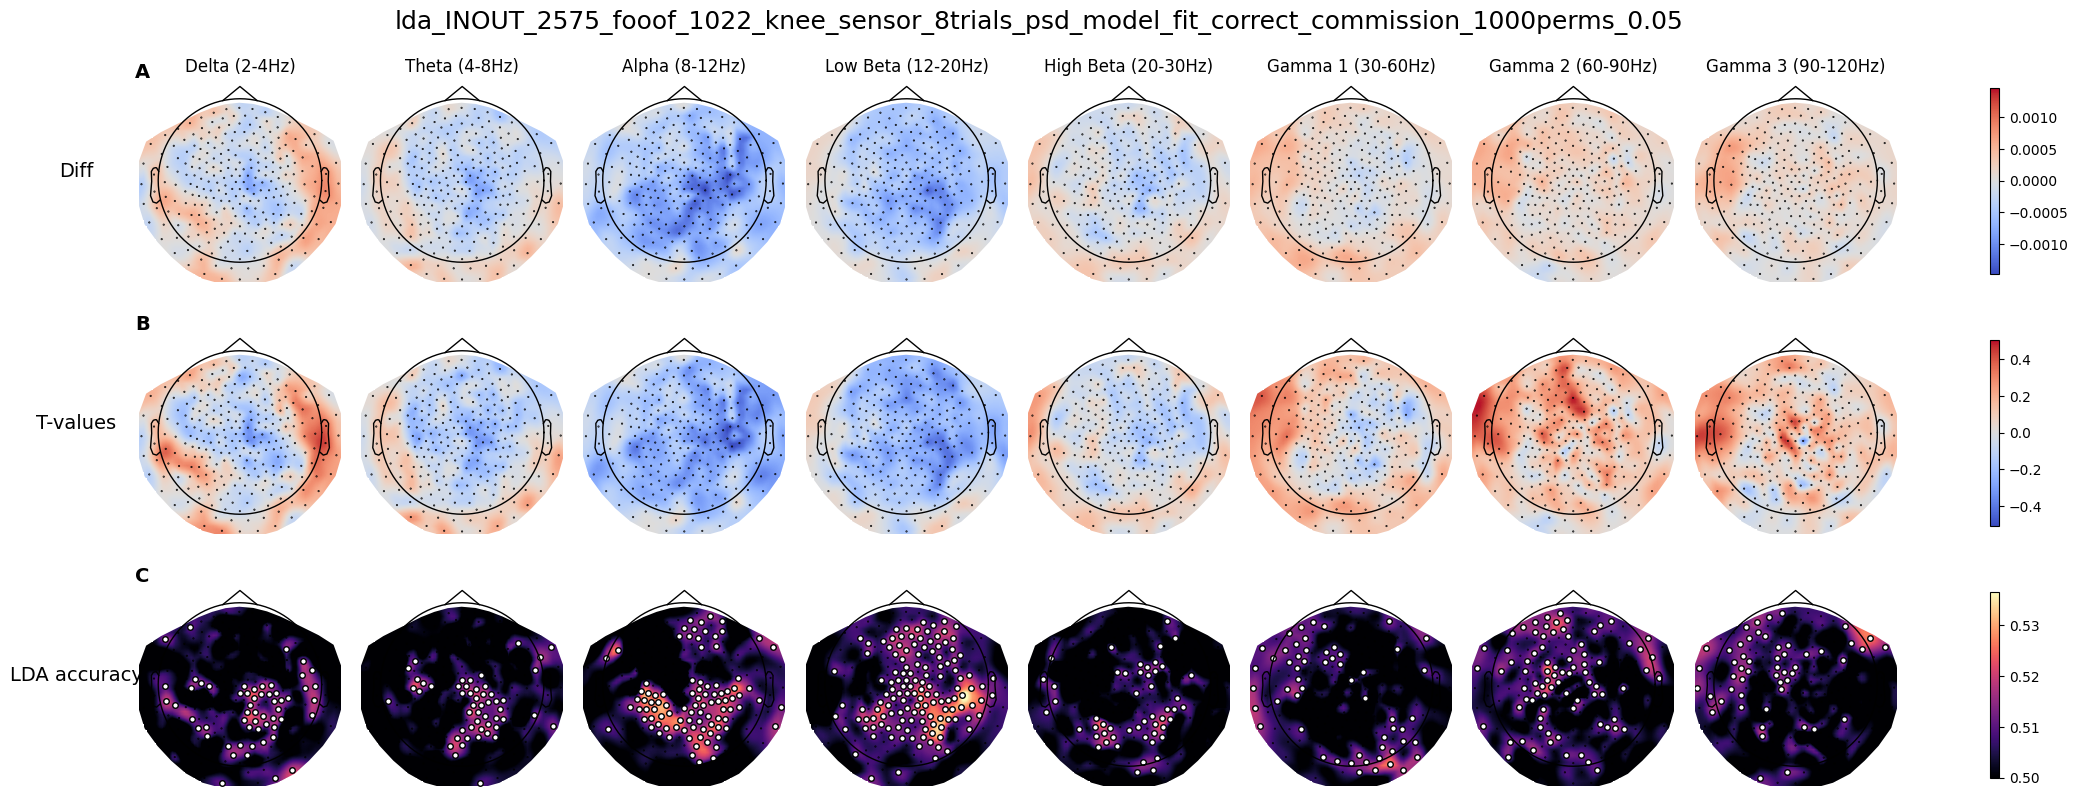

In [7]:
# Load data
## TRIAL-LEVEL
feature = 'fooof_1022_knee_sensor_8trials'
feat_to_get = 'psd_model_fit'
classif = 'INOUT_2575'
trial_type_to_get = ['correct_commission']
trial_type_formatted = '-'.join(trial_type_to_get)

alpha = 0.05
n_perms = 1000

classif_name_data = f'{classif}_{feature}_{feat_to_get}_{trial_type_formatted}'

loaded_data_filename = f'../tmp/{classif_name_data}.pkl'
if not op.exists(loaded_data_filename):
    feature_fpath = op.join(saflow.BIDS_PATH, 'derivatives', feature)
    X, y, groups, VTC, task = load_fooof_data(feature, feature_fpath, feat_to_get, trial_type_to_get, classif=classif)
    with open(loaded_data_filename, 'wb') as f:
        pkl.dump([X, y, groups, VTC, task], f)
else:
    with open(loaded_data_filename, 'rb') as f:
        X, y, groups, VTC, task = pkl.load(f)
        
X_bal, y_bal, gr_bal = balance_data(X,y,groups)
print(f'Data shape before balance : {X.shape} and after balance : {X_bal.shape}')


# Classif SF

picks, chan_info = get_meg_picks_and_info('12', '02')
classif_name = f'lda_{classif}_{feature}_{feat_to_get}_{trial_type_formatted}_{n_perms}perms'
output_filename = f'../tmp/{classif_name}.pkl'

if not op.exists(output_filename):
    all_results = singlefeat_classif(LinearDiscriminantAnalysis(), LeaveOneGroupOut(), X_bal, y_bal, gr_bal, n_perms=n_perms)
    with open(output_filename, 'wb') as f:
        pkl.dump(all_results, f)
else:
    with open(output_filename, 'rb') as f:
        all_results = pkl.load(f)

# Plot results


picks, chan_info = get_meg_picks_and_info('12', '02')

X_raw, X_corrected, X_model, X_ksor, y_subjlevel, groups_subjlevel = load_subjlevel_fooofs(feature, feature_fpath)
X_contrast, tvals, pvals = simple_contrast(X_bal, y_bal, gr_bal)
#X_contrast, tvals, pvals = subject_contrast(X_raw, y_subjlevel)
qvals = np.array([fdrcorrection(pvals[x,:])[1] for x in range(pvals.shape[0])])
pvals_masks = np.array([mask_pvals(pvals[x,:], alpha) for x in range(pvals.shape[0])])
tmax_pvals = apply_tmax(all_results)
tmax_pvals_masks = np.array([mask_pvals(tmax_pvals[x,:], alpha) for x in range(tmax_pvals.shape[0])])
masks = np.array([np.zeros_like(pvals_masks), pvals_masks, tmax_pvals_masks])

titles_x = ['Delta (2-4Hz)', 'Theta (4-8Hz)', 'Alpha (8-12Hz)', 
            'Low Beta (12-20Hz)', 'High Beta (20-30Hz)',
            'Gamma 1 (30-60Hz)', 'Gamma 2 (60-90Hz)', 'Gamma 3 (90-120Hz)']
titles_y = ['Diff', 'T-values', 'LDA accuracy']
cmap = ['coolwarm', 'coolwarm', 'magma']
maxval_contrast = np.max(abs(X_contrast))
maxval_tvals = np.max(abs(tvals))
vlims = [(-maxval_contrast,maxval_contrast), (-maxval_tvals,maxval_tvals), (0.5,np.max(all_results['scores']))]
fig, axes = grid_topoplot(np.array([X_contrast, tvals, all_results['scores']]), 
                          chan_info, 
                          titles_x=titles_x, titles_y=titles_y, 
                          masks=masks, 
                          cmap=cmap, 
                          vlims=vlims, 
                          title=f'{classif_name}_{alpha}')

Subject sub-04 max trials : 36 OUT
36 113
36
Subject sub-05 max trials : 154 IN
154 187
154
Subject sub-06 max trials : 60 OUT
60 93
60
Subject sub-07 max trials : 146 OUT
146 193
146
Subject sub-08 max trials : 30 OUT
38 30
30
Subject sub-09 max trials : 144 IN
178 144
144
Subject sub-10 max trials : 153 IN
153 172
153
Subject sub-11 max trials : 110 OUT
110 159
110
Subject sub-12 max trials : 169 OUT
169 255
169
Subject sub-13 max trials : 139 IN
139 202
139
Subject sub-14 max trials : 216 IN
216 219
216
Subject sub-15 max trials : 9 IN
24 9
9
Subject sub-17 max trials : 202 OUT
202 225
202
Subject sub-18 max trials : 25 OUT
25 54
25
Subject sub-20 max trials : 113 OUT
113 180
113
Subject sub-21 max trials : 317 OUT
321 317
317
Subject sub-22 max trials : 127 OUT
127 233
127
Subject sub-23 max trials : 11 OUT
72 11
11
Subject sub-24 max trials : 113 IN
113 200
113
Subject sub-26 max trials : 224 IN
224 224
224
Subject sub-28 max trials : 258 IN
258 321
258
Subject sub-29 max trials :

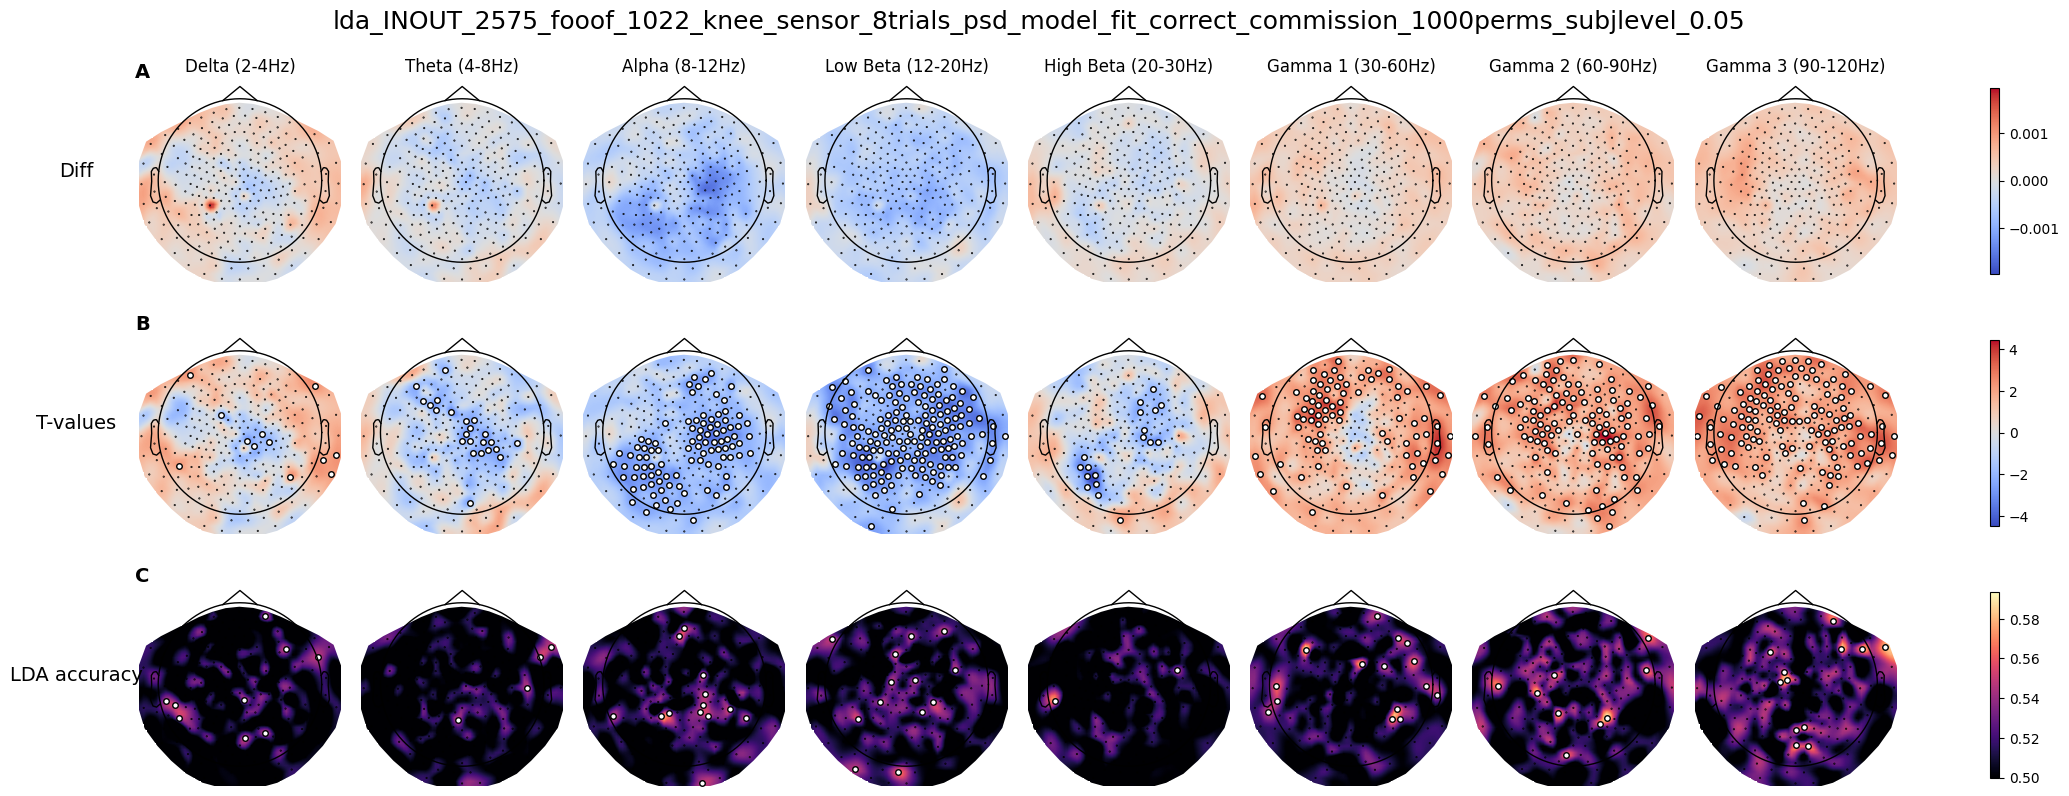

In [8]:
# Load data
## SUBJECT-LEVEL
feature = 'fooof_1022_knee_sensor_8trials'
feat_to_get = 'psd_model_fit'
classif = 'INOUT_2575'
trial_type_to_get = ['correct_commission']
trial_type_formatted = '-'.join(trial_type_to_get)

alpha = 0.05
n_perms = 1000

classif_name_data = f'{classif}_{feature}_{feat_to_get}_{trial_type_formatted}'

loaded_data_filename = f'../tmp/{classif_name_data}.pkl'
if not op.exists(loaded_data_filename):
    feature_fpath = op.join(saflow.BIDS_PATH, 'derivatives', feature)
    X, y, groups, VTC, task = load_fooof_data(feature, feature_fpath, feat_to_get, trial_type_to_get, classif=classif)
    with open(loaded_data_filename, 'wb') as f:
        pkl.dump([X, y, groups, VTC, task], f)
else:
    with open(loaded_data_filename, 'rb') as f:
        X, y, groups, VTC, task = pkl.load(f)
        
X_bal, y_bal, gr_bal = balance_data(X,y,groups)
print(f'Data shape before balance : {X.shape} and after balance : {X_bal.shape}')
X_raw, X_corrected, X_model, X_ksor, y_subjlevel, groups_subjlevel = load_subjlevel_fooofs(feature, feature_fpath)
#X_contrast, tvals, pvals = simple_contrast(X_bal, y_bal, gr_bal)
X_contrast, tvals, pvals = subject_contrast(X_model, y_subjlevel)

# Classif SF
picks, chan_info = get_meg_picks_and_info('12', '02')
classif_name = f'lda_{classif}_{feature}_{feat_to_get}_{trial_type_formatted}_{n_perms}perms_subjlevel'
output_filename = f'../tmp/{classif_name}.pkl'

if not op.exists(output_filename):
    all_results = singlefeat_classif(LinearDiscriminantAnalysis(), LeaveOneGroupOut(), X_model, y_subjlevel, groups_subjlevel, n_perms=n_perms)
    with open(output_filename, 'wb') as f:
        pkl.dump(all_results, f)
else:
    with open(output_filename, 'rb') as f:
        all_results = pkl.load(f)

# Plot results
picks, chan_info = get_meg_picks_and_info('12', '02')

qvals = np.array([fdrcorrection(pvals[x,:])[1] for x in range(pvals.shape[0])])
pvals_masks = np.array([mask_pvals(pvals[x,:], alpha) for x in range(pvals.shape[0])])
tmax_pvals = apply_tmax(all_results)
tmax_pvals_masks = np.array([mask_pvals(tmax_pvals[x,:], alpha) for x in range(tmax_pvals.shape[0])])
masks = np.array([np.zeros_like(pvals_masks), pvals_masks, tmax_pvals_masks])

titles_x = ['Delta (2-4Hz)', 'Theta (4-8Hz)', 'Alpha (8-12Hz)', 
            'Low Beta (12-20Hz)', 'High Beta (20-30Hz)',
            'Gamma 1 (30-60Hz)', 'Gamma 2 (60-90Hz)', 'Gamma 3 (90-120Hz)']
titles_y = ['Diff', 'T-values', 'LDA accuracy']
cmap = ['coolwarm', 'coolwarm', 'magma']
maxval_contrast = np.max(abs(X_contrast))
maxval_tvals = np.max(abs(tvals))
vlims = [(-maxval_contrast,maxval_contrast), (-maxval_tvals,maxval_tvals), (0.5,np.max(all_results['scores']))]
fig, axes = grid_topoplot(np.array([X_contrast, tvals, all_results['scores']]), 
                          chan_info, 
                          titles_x=titles_x, titles_y=titles_y, 
                          masks=masks, 
                          cmap=cmap, 
                          vlims=vlims, 
                          title=f'{classif_name}_{alpha}')

## KSOR

sub-04_task-gradCPT_meg.pkl
sub-04_task-gradCPT_run-02_meg.pkl
sub-04_task-gradCPT_run-02_meg_magic.pkl
sub-04_task-gradCPT_run-03_meg.pkl
sub-04_task-gradCPT_run-03_meg_magic.pkl
sub-04_task-gradCPT_run-04_meg.pkl
sub-04_task-gradCPT_run-04_meg_magic.pkl
sub-04_task-gradCPT_run-06_meg.pkl
sub-04_task-gradCPT_run-06_meg_magic.pkl
sub-04_task-gradCPT_run-07_meg.pkl
sub-04_task-gradCPT_run-07_meg_magic.pkl
sub-05_task-gradCPT_meg.pkl
sub-05_task-gradCPT_run-02_meg.pkl
sub-05_task-gradCPT_run-02_meg_magic.pkl
sub-05_task-gradCPT_run-03_meg.pkl
sub-05_task-gradCPT_run-04_meg.pkl
sub-05_task-gradCPT_run-04_meg_magic.pkl
sub-05_task-gradCPT_run-05_meg.pkl
sub-05_task-gradCPT_run-05_meg_magic.pkl
sub-05_task-gradCPT_run-06_meg.pkl
sub-05_task-gradCPT_run-06_meg_magic.pkl
sub-05_task-gradCPT_run-07_meg.pkl
sub-05_task-gradCPT_run-07_meg_magic.pkl
sub-06_task-gradCPT_meg.pkl
sub-06_task-gradCPT_run-02_meg.pkl
sub-06_task-gradCPT_run-02_meg_magic.pkl
sub-06_task-gradCPT_run-03_meg.pkl
sub-06_tas

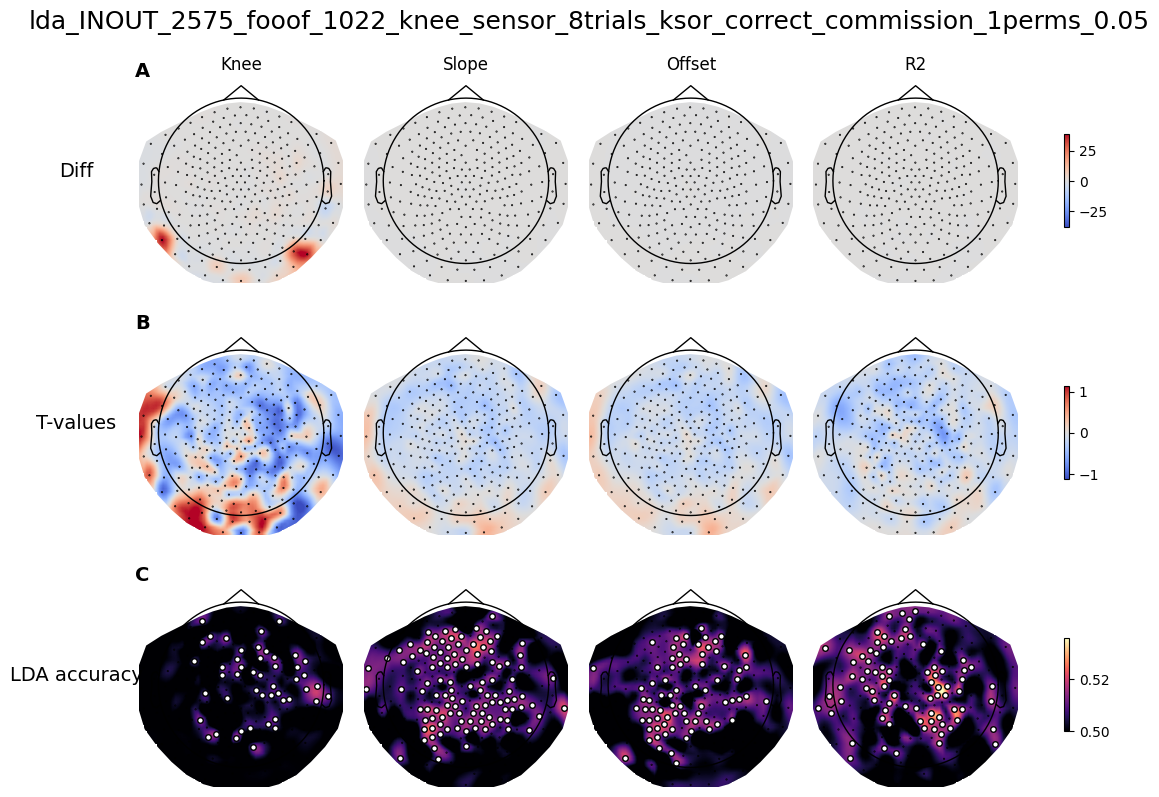

In [2]:
# Load data
feature = 'fooof_1022_knee_sensor_8trials'
feat_to_get = 'ksor'
classif = 'INOUT_2575'
trial_type_to_get = ['correct_commission']
trial_type_formatted = '-'.join(trial_type_to_get)

alpha = 0.05
n_perms = 1

classif_name_data = f'{classif}_{feature}_{feat_to_get}_{trial_type_formatted}'

loaded_data_filename = f'../tmp/{classif_name_data}.pkl'
if not op.exists(loaded_data_filename):
    feature_fpath = op.join(saflow.BIDS_PATH, 'derivatives', feature)
    X, y, groups, VTC, task = load_fooof_data(feature, feature_fpath, feat_to_get, trial_type_to_get, classif=classif)
    with open(loaded_data_filename, 'wb') as f:
        pkl.dump([X, y, groups, VTC, task], f)
else:
    with open(loaded_data_filename, 'rb') as f:
        X, y, groups, VTC, task = pkl.load(f)
        
X_bal, y_bal, gr_bal = balance_data(X,y,groups)
print(f'Data shape before balance : {X.shape} and after balance : {X_bal.shape}')


# Classif SF

picks, chan_info = get_meg_picks_and_info('12', '02')
classif_name = f'lda_{classif}_{feature}_{feat_to_get}_{trial_type_formatted}_{n_perms}perms'
output_filename = f'../tmp/{classif_name}.pkl'

if not op.exists(output_filename):
    all_results = singlefeat_classif(LinearDiscriminantAnalysis(), LeaveOneGroupOut(), X_bal, y_bal, gr_bal, n_perms=n_perms)
    with open(output_filename, 'wb') as f:
        pkl.dump(all_results, f)
else:
    with open(output_filename, 'rb') as f:
        all_results = pkl.load(f)

# Plot results
picks, chan_info = get_meg_picks_and_info('12', '02')

X_raw, X_corrected, X_model, X_ksor, y_subjlevel, groups_subjlevel = load_subjlevel_fooofs(feature, feature_fpath)
X_contrast, tvals, pvals = simple_contrast(X_bal, y_bal, gr_bal)
#X_contrast, tvals, pvals = subject_contrast(X_ksor, y_subjlevel)

qvals = np.array([fdrcorrection(pvals[x,:])[1] for x in range(pvals.shape[0])])
pvals_masks = np.array([mask_pvals(pvals[x,:], alpha) for x in range(pvals.shape[0])])
tmax_pvals = apply_tmax(all_results)
tmax_pvals_masks = np.array([mask_pvals(tmax_pvals[x,:], alpha) for x in range(tmax_pvals.shape[0])])
masks = np.array([np.zeros_like(pvals_masks), pvals_masks, tmax_pvals_masks])

titles_x = ['Knee', 'Slope', 'Offset', 'R2']
titles_y = ['Diff', 'T-values', 'LDA accuracy']
cmap = ['coolwarm', 'coolwarm', 'magma']
maxval_contrast = np.max(abs(X_contrast))
maxval_tvals = np.max(abs(tvals))
vlims = [(-maxval_contrast,maxval_contrast), (-maxval_tvals,maxval_tvals), (0.5,np.max(all_results['scores']))]
fig, axes = grid_topoplot(np.array([X_contrast, tvals, all_results['scores']]), 
                          chan_info, 
                          titles_x=titles_x, titles_y=titles_y, 
                          masks=masks, 
                          cmap=cmap, 
                          vlims=vlims, 
                          title=f'{classif_name}_{alpha}')

## KSOR subject-averages

Subject sub-04 max trials : 36 OUT
36 113
36
Subject sub-05 max trials : 154 IN
154 187
154
Subject sub-06 max trials : 60 OUT
60 93
60
Subject sub-07 max trials : 146 OUT
146 193
146
Subject sub-08 max trials : 30 OUT
38 30
30
Subject sub-09 max trials : 144 IN
178 144
144
Subject sub-10 max trials : 153 IN
153 172
153
Subject sub-11 max trials : 110 OUT
110 159
110
Subject sub-12 max trials : 169 OUT
169 255
169
Subject sub-13 max trials : 139 IN
139 202
139
Subject sub-14 max trials : 216 IN
216 219
216
Subject sub-15 max trials : 9 IN
24 9
9
Subject sub-17 max trials : 202 OUT
202 225
202
Subject sub-18 max trials : 25 OUT
25 54
25
Subject sub-20 max trials : 113 OUT
113 180
113
Subject sub-21 max trials : 317 OUT
321 317
317
Subject sub-22 max trials : 127 OUT
127 233
127
Subject sub-23 max trials : 11 OUT
72 11
11
Subject sub-24 max trials : 113 IN
113 200
113
Subject sub-26 max trials : 224 IN
224 224
224
Subject sub-28 max trials : 258 IN
258 321
258
Subject sub-29 max trials :

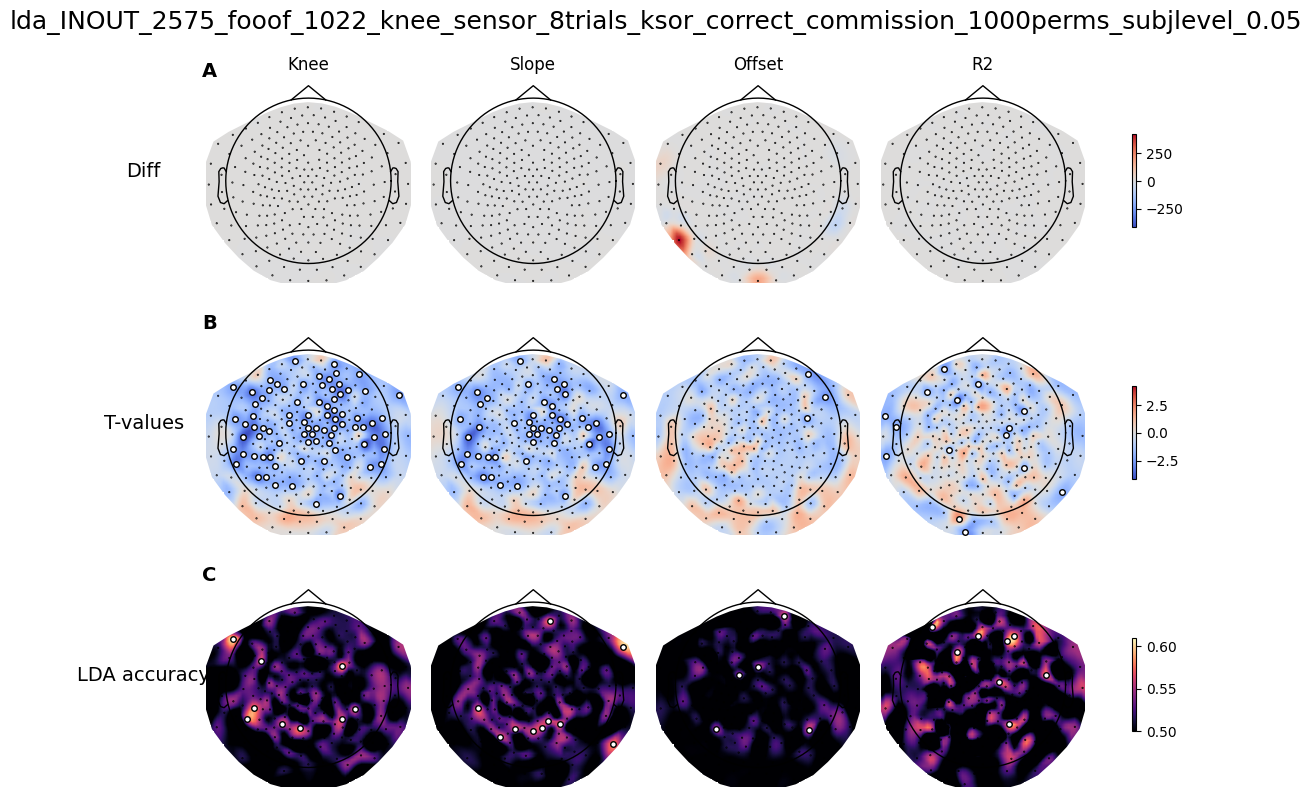

In [10]:
# Load data
feature = 'fooof_1022_knee_sensor_8trials'
feat_to_get = 'ksor'
classif = 'INOUT_2575'
trial_type_to_get = ['correct_commission']
trial_type_formatted = '-'.join(trial_type_to_get)

alpha = 0.05
n_perms = 1000

classif_name_data = f'{classif}_{feature}_{feat_to_get}_{trial_type_formatted}'

loaded_data_filename = f'../tmp/{classif_name_data}.pkl'
if not op.exists(loaded_data_filename):
    feature_fpath = op.join(saflow.BIDS_PATH, 'derivatives', feature)
    X, y, groups, VTC, task = load_fooof_data(feature, feature_fpath, feat_to_get, trial_type_to_get, classif=classif)
    with open(loaded_data_filename, 'wb') as f:
        pkl.dump([X, y, groups, VTC, task], f)
else:
    with open(loaded_data_filename, 'rb') as f:
        X, y, groups, VTC, task = pkl.load(f)
        
X_bal, y_bal, gr_bal = balance_data(X,y,groups)
print(f'Data shape before balance : {X.shape} and after balance : {X_bal.shape}')

X_raw, X_corrected, X_model, X_ksor, y_subjlevel, groups_subjlevel = load_subjlevel_fooofs(feature, feature_fpath)
X_contrast, tvals, pvals = subject_contrast(X_ksor, y_subjlevel)

# Classif SF

picks, chan_info = get_meg_picks_and_info('12', '02')
classif_name = f'lda_{classif}_{feature}_{feat_to_get}_{trial_type_formatted}_{n_perms}perms_subjlevel'
output_filename = f'../tmp/{classif_name}.pkl'

if not op.exists(output_filename):
    all_results = singlefeat_classif(LinearDiscriminantAnalysis(), LeaveOneGroupOut(), X_ksor, y_subjlevel, groups_subjlevel, n_perms=n_perms)
    with open(output_filename, 'wb') as f:
        pkl.dump(all_results, f)
else:
    with open(output_filename, 'rb') as f:
        all_results = pkl.load(f)

# Plot results
picks, chan_info = get_meg_picks_and_info('12', '02')



qvals = np.array([fdrcorrection(pvals[x,:])[1] for x in range(pvals.shape[0])])
pvals_masks = np.array([mask_pvals(pvals[x,:], alpha) for x in range(pvals.shape[0])])
tmax_pvals = apply_tmax(all_results)
tmax_pvals_masks = np.array([mask_pvals(tmax_pvals[x,:], alpha) for x in range(tmax_pvals.shape[0])])
masks = np.array([np.zeros_like(pvals_masks), pvals_masks, tmax_pvals_masks])

titles_x = ['Knee', 'Slope', 'Offset', 'R2']
titles_y = ['Diff', 'T-values', 'LDA accuracy']
cmap = ['coolwarm', 'coolwarm', 'magma']
maxval_contrast = np.max(abs(X_contrast))
maxval_tvals = np.max(abs(tvals))
vlims = [(-maxval_contrast,maxval_contrast), (-maxval_tvals,maxval_tvals), (0.5,np.max(all_results['scores']))]
fig, axes = grid_topoplot(np.array([X_contrast, tvals, all_results['scores']]), 
                          chan_info, 
                          titles_x=titles_x, titles_y=titles_y, 
                          masks=masks, 
                          cmap=cmap, 
                          vlims=vlims, 
                          title=f'{classif_name}_{alpha}')

In [11]:
X_raw.shape

(8, 64, 270)

In [12]:
# Compute tmax trick with permutations



print(f'{tmax_pvals.shape}')


(4, 270)


In [13]:
da_perms.shape

NameError: name 'da_perms' is not defined

In [ ]:
[np.zeros_like(pvals_masks), pvals_masks, np.zeros_like(pvals_masks)]

[array([[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]]),
 array([[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]]),
 array([[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, Fal

In [ ]:
feature = 'fooof_1022_knee_sensor_8trials'
feature_fpath = op.join(saflow.BIDS_PATH, 'derivatives', feature)


In [ ]:
X_raw.shape

(8, 64, 270)

# Deprec

Opening raw data file /media/hyruuk/Storage2/DATA/saflow/bids/derivatives/preprocessed/sub-05/meg/sub-05_task-gradCPT_run-04_proc-clean_meg.fif...
    Read 5 compensation matrices
    Range : 0 ... 587999 =      0.000 ...   489.999 secs
Ready.
Current compensation grade : 3
Reading events from /media/hyruuk/Storage2/DATA/saflow/bids/derivatives/preprocessed/sub-05/meg/sub-05_task-gradCPT_run-04_proc-clean_events.tsv.
Reading channel info from /media/hyruuk/Storage2/DATA/saflow/bids/derivatives/preprocessed/sub-05/meg/sub-05_task-gradCPT_run-04_proc-clean_channels.tsv.
Cannot verify that the cHPI frequencies from the MEG JSON sidecar file correspond to the raw data.
Not fully anonymizing info - keeping his_id, sex, and hand info
Effective window size : 0.852 (s)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of  12 | elapsed:  1.3min remaining:  2.5min
[Parallel(n_jobs=-1)]: Done   7 out of  12 | elapsed:  1.3min remaining:   55.5s
[Parallel(n_jobs=-1)]: Done  10 out of  12 | elapsed:  1.5min remaining:   17.4s
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:  1.6min finished


Running FOOOFGroup across 555 power spectra.

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 1.17
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

Running FOOOFGroup across 555 power spectra.

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 1.17
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

                                                                                                  
                                       FOOOF - GROUP RESULTS                                      
        

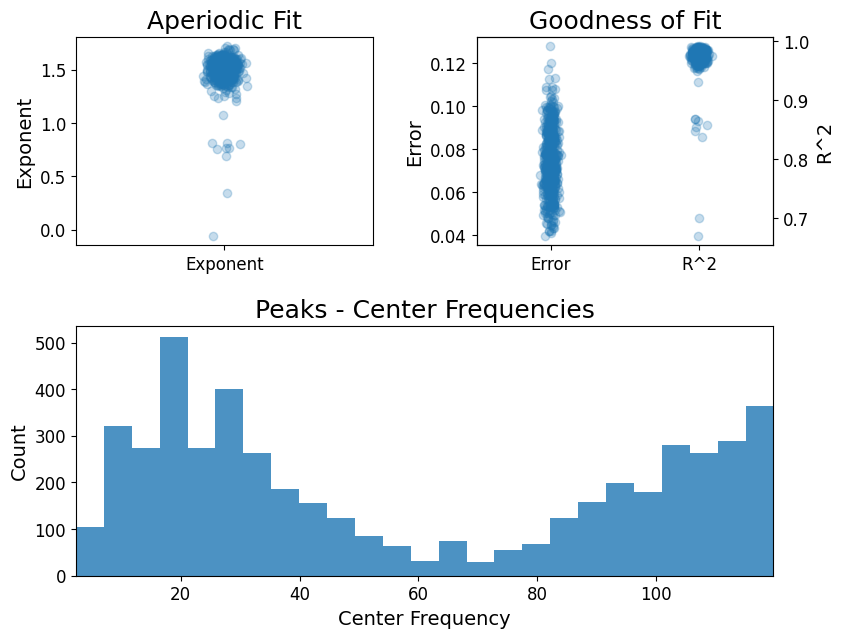

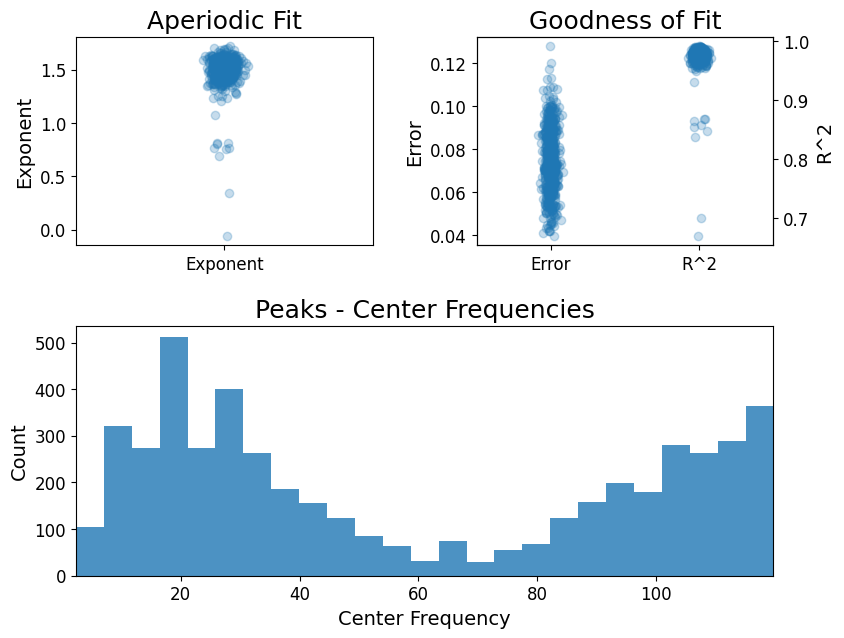

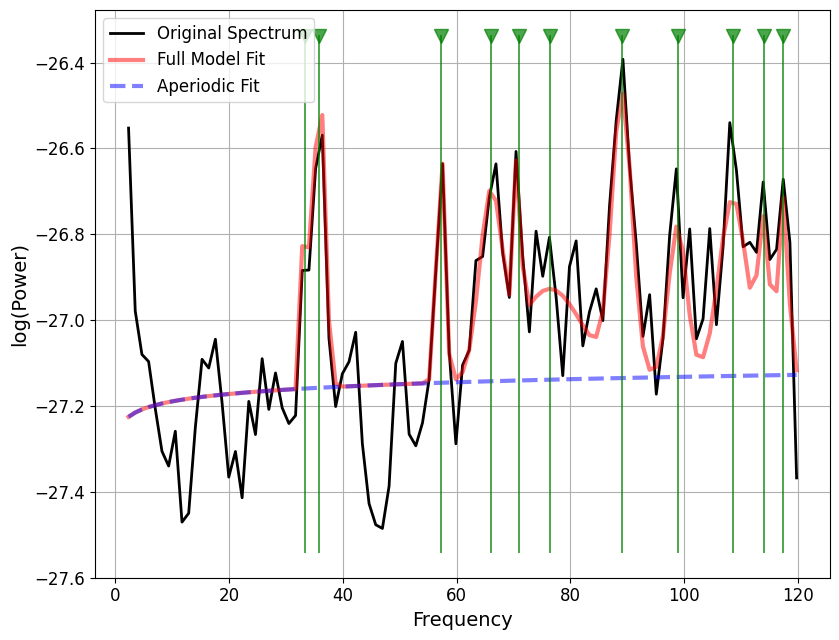

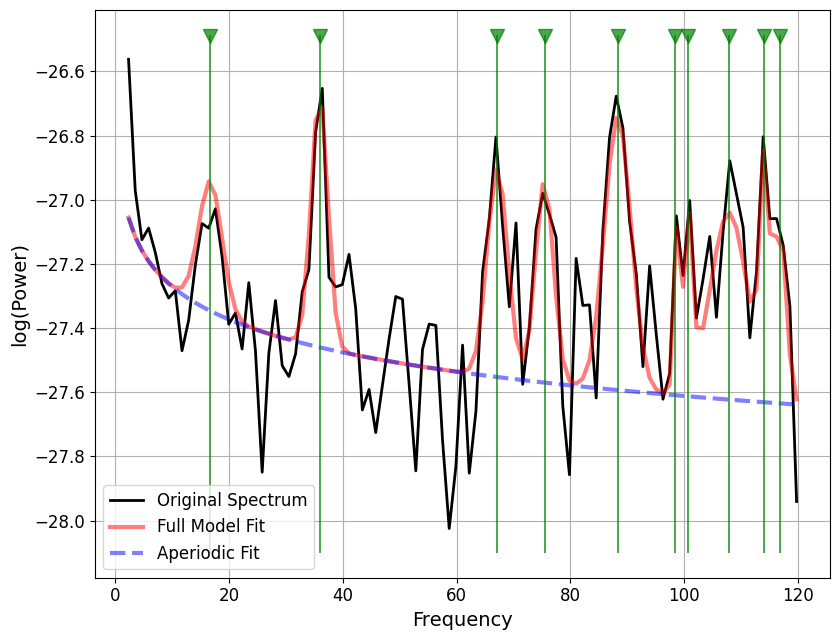

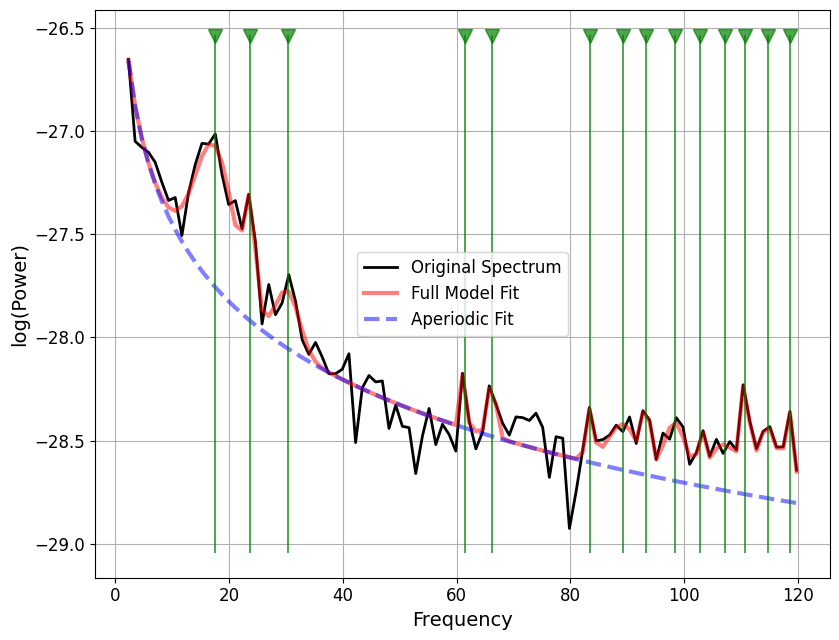

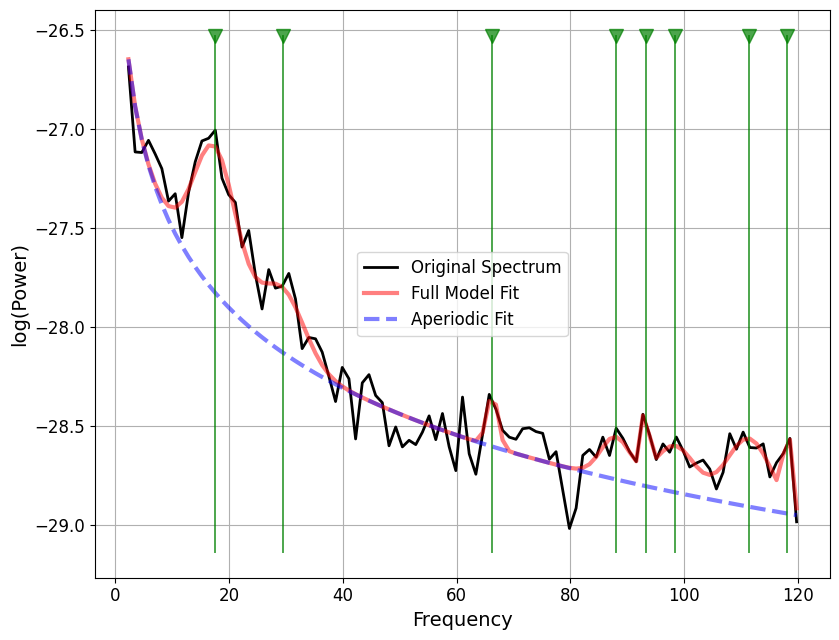

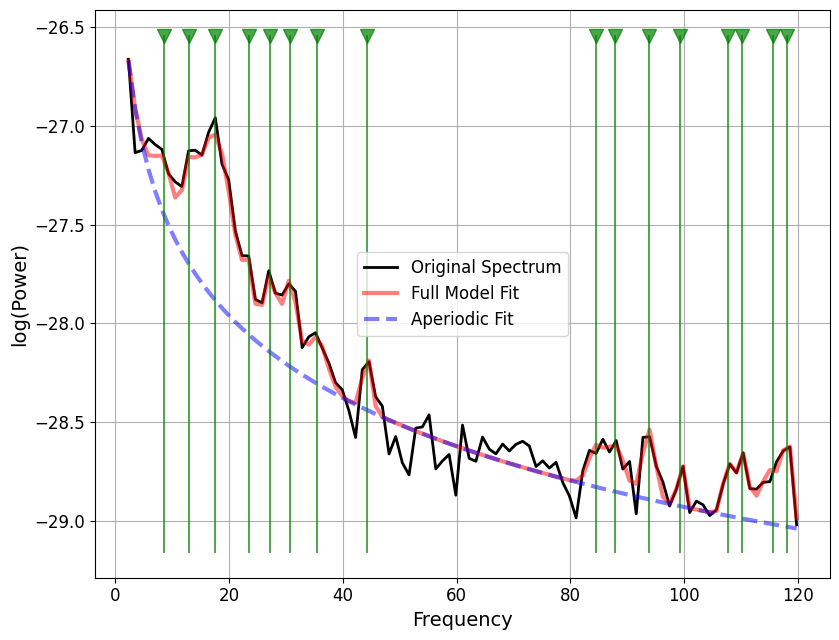

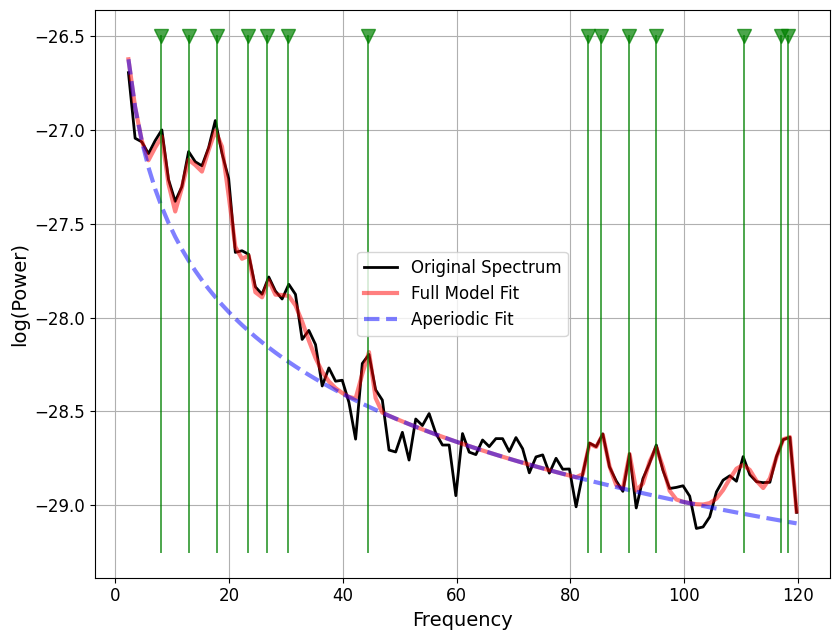

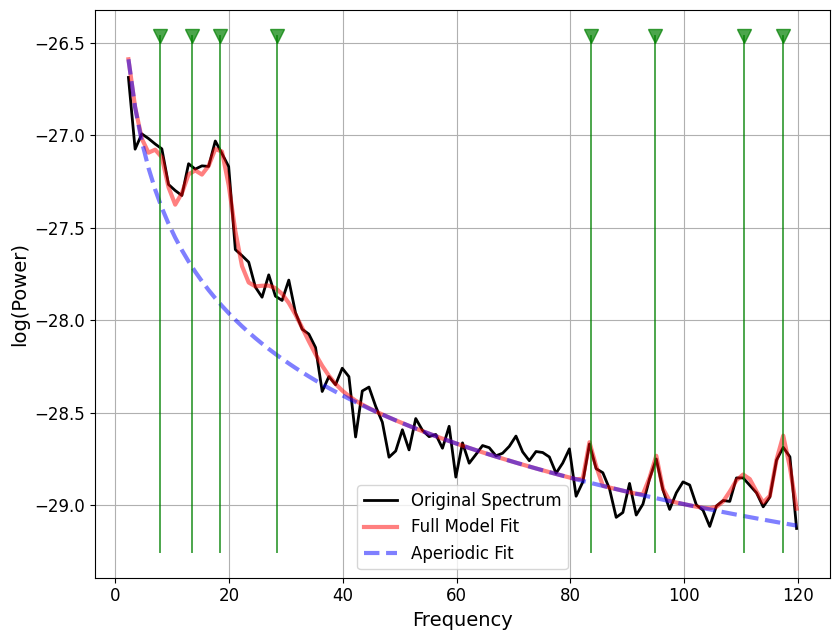

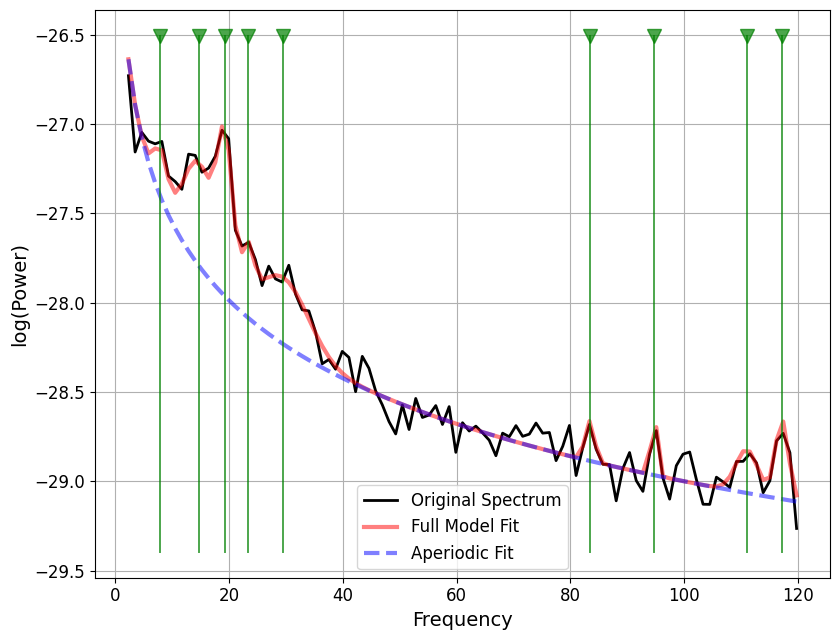

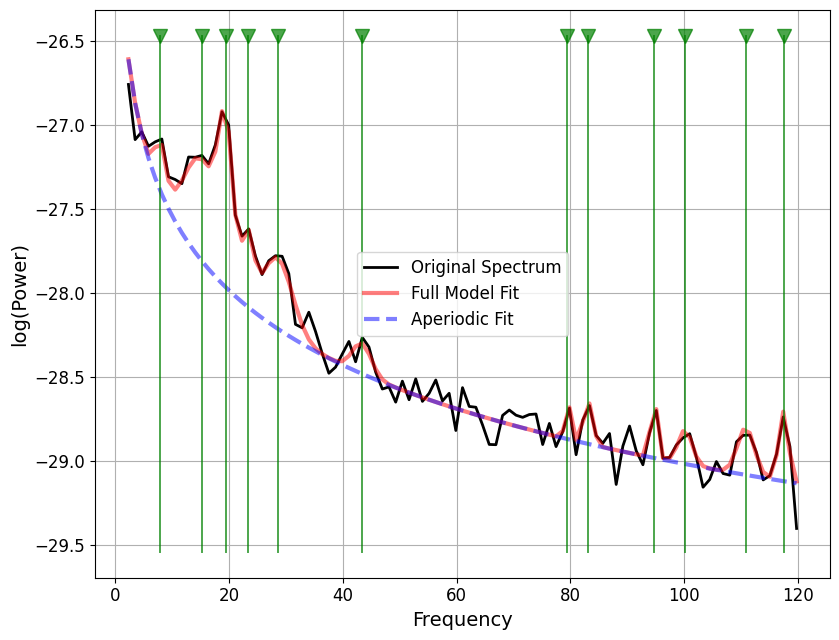

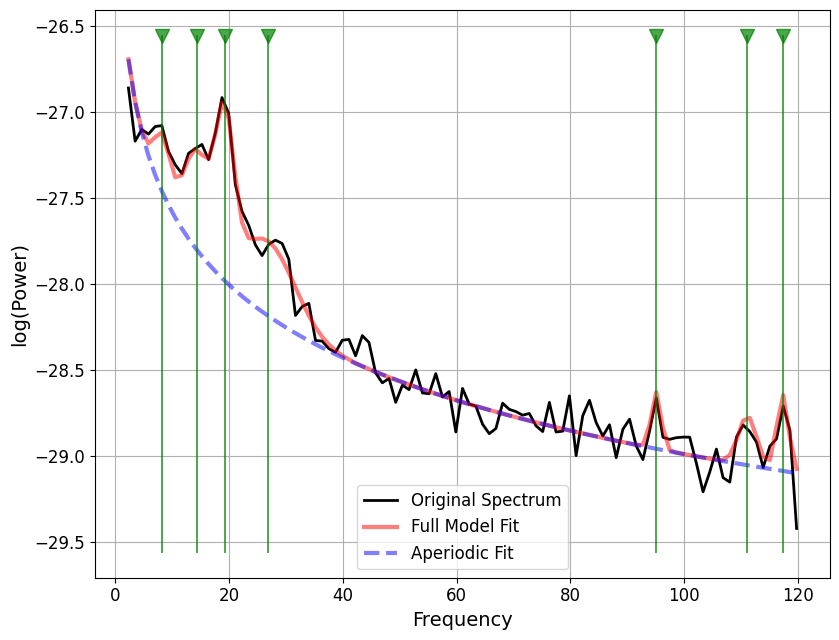

In [ ]:
## Fooof debug

from saflow.features.utils import create_fnames, segment_sourcelevel

subject = '05'
run = '04'

filepaths = create_fnames(subject, run)
raw = mne_bids.read_raw_bids(filepaths['preproc'])
data = raw.get_data()
sfreq = raw.info['sfreq']
meg_picks = mne.pick_types(raw.info, meg=True, ref_meg=False, eeg=False, eog=False)
data = data[meg_picks,:]

segmented_array, events_idx, events_dicts = segment_sourcelevel(data, filepaths, sfreq=sfreq, n_events_window=8)
n_fft=1022
welch_array = mne.time_frequency.psd_array_welch(segmented_array[:,:,:], sfreq=sfreq, n_jobs=-1, n_fft=1022, n_overlap=959, average='mean')

# Try to FOOOF
from fooof import FOOOFGroup
# Define `peak_width_limit` setting
peak_width = [1, 8]
# Define `max_n_peaks` setting
n_peaks = 4
# Define `min_peak_height` setting
peak_height = 0.10
# Define frequency range
PSD_range = [2, 120]
# Initialize a model object for spectral parameterization, with some settings 
fg = FOOOFGroup(aperiodic_mode='fixed')#peak_width_limits=peak_width, max_n_peaks=n_peaks, min_peak_height=peak_height, verbose=False, aperiodic_mode='fixed')



epoch_data = welch_array[0][:,10,:]
fg.fit(welch_array[1], epoch_data, PSD_range)
fg.plot();
fg.report()
for i in range(10):
    fg.get_fooof(i).plot(plot_peaks='line')

In [ ]:
# Create Magic dict

feature = 'fooof'
feature_fpath = op.join(saflow.BIDS_PATH, 'derivatives', feature)


for sub in sorted(os.listdir(feature_fpath)):
    for run in saflow.BLOCS_LIST:
        run = '0' + str(run)
        fname = op.join(feature_fpath, sub, 'meg', f'{sub}_task-gradCPT_run-{run}_meg.pkl')
        fname_output = fname.replace('.pkl', '_magic.pkl')
        if not op.exists(fname_output):
            magic_dict = []
            with open(fname, 'rb') as f:
                data = pickle.load(f)
            print(magic_dict)
            for trial_idx in range(len(data['trial_fooofs'])):

                INOUT = data['info'][trial_idx]['INOUT']
                print(f'Adding trial {trial_idx} of run {run} of subject {sub}')
                for chan_idx in range(len(data['trial_fooofs'][trial_idx])):
                    psd_raw = data['trial_fooofs'][trial_idx].get_fooof(chan_idx).power_spectrum
                    freq_bins = data['trial_fooofs'][trial_idx].get_fooof(chan_idx).freqs
                    0/0
                    if INOUT == 'IN':
                        psd_corrected = data['trial_fooofs'][trial_idx].get_fooof(chan_idx).power_spectrum - data['IN_fooofs'].get_fooof(chan_idx)._ap_fit
                    elif INOUT == 'OUT':
                        psd_corrected = data['trial_fooofs'][trial_idx].get_fooof(chan_idx).power_spectrum - data['OUT_fooofs'].get_fooof(chan_idx)._ap_fit

                    psd_model_fit = data['trial_fooofs'][trial_idx].get_fooof(chan_idx).fooofed_spectrum_
                    exponent = data['trial_fooofs'][trial_idx].get_fooof(chan_idx).aperiodic_params_[-1]
                    offset = data['trial_fooofs'][trial_idx].get_fooof(chan_idx).aperiodic_params_[0]
                    knee = data['trial_fooofs'][trial_idx].get_fooof(chan_idx).aperiodic_params_[1]
                    r_squared = data['trial_fooofs'][trial_idx].get_fooof(chan_idx).r_squared_
                    
                    data_dict = {'psd_raw': psd_raw, 
                                'psd_corrected': psd_corrected, 
                                'psd_model_fit': psd_model_fit, 
                                'exponent': exponent, 
                                'offset': offset, 
                                'knee': knee, 
                                'r_squared': r_squared,
                                'info': data['info'][trial_idx],
                                'freq_bins': freq_bins}
                    
                    magic_dict.append(data_dict)
            fname_output = fname.replace('.pkl', '_magic.pkl')
            with open(fname_output, 'wb') as f:
                pickle.dump(magic_dict, f)


In [ ]:
output_fname = op.join('/home/hyruuk/GitHub/cocolab/cc_saflow/tmp/', 'subject_averaged_fooofs.pkl')
with open(output_fname, 'rb') as f:
    fooof_array = pickle.load(f)

In [ ]:
def average_bands_from_bands(fm, freqs=saflow.FREQS):
    fooof_freqs = fm.freqs
    original_bands = []
    fooof_bands = []
    original_corrected = []
    for band in freqs:
        freq_mask = np.where((fooof_freqs >= band[0]) & (fooof_freqs <= band[1]))[0]
        original = np.mean(fm.power_spectrum[freq_mask])
        original_bands.append(original)

        fooof = np.mean(fm.fooofed_spectrum_[freq_mask])
        fooof_bands.append(fooof)

        corrected = fm.power_spectrum - fm._ap_fit
        original_corrected.append(np.mean(corrected[freq_mask]))
    
    exponent = fm.get_params('aperiodic_params', 'exponent')
    offset = fm.get_params('aperiodic_params', 'offset')
    r_squared = fm.get_params('r_squared')
    return original_bands, fooof_bands, original_corrected, exponent, offset, r_squared

def get_data_matrix(fooof_array):
    original_bands_array = []
    fooof_bands_array = []
    original_corrected_array = []
    exponent_array = []
    offset_array = []
    r_squared_array = []

    for cond_idx in range(fooof_array.shape[0]):
        original_bands_subj = []
        fooof_bands_subj = []
        original_corrected_subj = []
        exponent_subj = []
        offset_subj = []
        r_squared_subj = []
        for subj_idx in range(fooof_array.shape[1]):
            original_bands_chans = []
            fooof_bands_chans = []
            original_corrected_chans = []
            exponent_chans = []
            offset_chans = []
            r_squared_chans = []
            for chan_idx in range(fooof_array.shape[2]):
                fm = fooof_array[cond_idx, subj_idx, chan_idx]
                original_bands, fooof_bands, original_corrected, exponent, offset, r_squared = average_bands_from_bands(fm)
                original_bands_chans.append(original_bands)
                fooof_bands_chans.append(fooof_bands)
                original_corrected_chans.append(original_corrected)
                exponent_chans.append(exponent)
                offset_chans.append(offset)
                r_squared_chans.append(r_squared)
            original_bands_subj.append(original_bands_chans)
            fooof_bands_subj.append(fooof_bands_chans)
            original_corrected_subj.append(original_corrected_chans)
            exponent_subj.append(exponent_chans)
            offset_subj.append(offset_chans)
            r_squared_subj.append(r_squared_chans)
        original_bands_array.append(original_bands_subj)
        fooof_bands_array.append(fooof_bands_subj)
        original_corrected_array.append(original_corrected_subj)
        exponent_array.append(exponent_subj)
        offset_array.append(offset_subj)
        r_squared_array.append(r_squared_subj)

        data = {'original_bands': np.array(original_bands_array),
                'fooof_bands': np.array(fooof_bands_array),
                'original_corrected': np.array(original_corrected_array),
                'exponent': np.array(exponent_array),
                'offset': np.array(offset_array),
                'r_squared': np.array(r_squared_array)}
    return data

data = get_data_matrix(fooof_array)

In [ ]:
data['original_bands'].shape

(2, 32, 270, 8)

In [ ]:
def format_data_for_classif(data, feature='original_bands'):
    X = []
    y = []
    groups = []
    for cond_idx in range(data[feature].shape[0]):
        for subj_idx in range(data[feature].shape[1]):
            X.append(data[feature][cond_idx, subj_idx])
            y.append(cond_idx)
            groups.append(subj_idx)
    X = np.array(X).transpose(2, 0, 1)
    y = np.array(y)
    groups = np.array(groups)
    return X, y, groups

X, y, groups = format_data_for_classif(data, feature='original_bands')

In [ ]:
X_contrast, tvals, pvals = simple_contrast(X, y, groups)


NameError: name 'y_avg' is not defined

In [ ]:
def simple_contrast(X, y, groups):
    """Computes subject-averages and contrasts between conditions."""
    n_features = X.shape[0]
    # Average each condition separately
    X_avg_by_cond = []
    for cond in np.unique(y):
        X_avg_by_cond.append(np.mean(X[y == cond], axis=0))
    # Compute normalized contrast (A - B)/B
    X_contrast = (X_avg_by_cond[0] - X_avg_by_cond[1]) / X_avg_by_cond[1]
    # Split conditions for ttest
    X_condA = X[y == 0]
    X_condB = X[y == 1]
    
    # Compute t-test
    tvals = []
    pvals = []
    for feature_idx in range(n_features):
        t, p = stats.ttest_rel(X_condA[:,feature_idx,:], X_condB[:,feature_idx,:], axis=0)
        tvals.append(t)
        pvals.append(p)
    tvals = np.array(tvals)
    pvals = np.array(pvals)
    return X_contrast, tvals, pvals


def singlefeat_classif(clf, cv, X, y, groups, n_perms=1):
    clf = LinearDiscriminantAnalysis()
    cv = LeaveOneGroupOut()

    all_scores, all_perm_scores, all_pvals = [], [], []
    for freq_idx in range(X.shape[0]):
        scores, perm_scores, pvals = [], [], []
        for chan_idx in range(X.shape[-1]):
            X_sf = X[freq_idx,:,chan_idx]
            score, permutation_scores, pvalue = permutation_test_score(clf, X=X_sf.reshape(-1, 1), y=y, groups=groups, cv=cv, n_permutations=n_perms, n_jobs=-1)
            scores.append(score)
            perm_scores.append(permutation_scores)
            pvals.append(pvalue)
            print(f'Computed feature {freq_idx} chan {chan_idx} Score {score}, pvalue {pvalue}')
        all_scores.append(scores)
        all_perm_scores.append(perm_scores)
        all_pvals.append(pvals)
        
    all_scores = np.array(all_scores)
    all_perm_scores = np.array(all_perm_scores)
    all_pvals = np.array(all_pvals)
    all_results = {'scores': all_scores, 'perm_scores': all_perm_scores, 'pvals': all_pvals}
    return all_results

In [ ]:
psd_raw.shape

(101,)

array([-27.40283668, -27.60067432, -27.73027081, -27.81499539,
       -27.83970157, -27.7703544 , -27.6179422 , -27.49639167,
       -27.52780242, -27.67697721, -27.80351006, -27.86104745,
       -27.91221753, -27.98781938, -28.05407603, -28.09683156,
       -28.14769769, -28.22789675, -28.31898519, -28.39251586,
       -28.43964152, -28.46832964, -28.48854962, -28.50572495,
       -28.52173177, -28.53704564, -28.55178283, -28.56599249,
       -28.57971173, -28.5929733 , -28.60580673, -28.61823879,
       -28.6302938 , -28.64199396, -28.65335954, -28.66440914,
       -28.67515983, -28.68562734, -28.69582616, -28.70576962,
       -28.71546992, -28.72493806, -28.73418348, -28.74321339,
       -28.75203138, -28.76063488, -28.76901088, -28.77712933,
       -28.78493361, -28.79232809, -28.79916393, -28.80522592,
       -28.81022511, -28.81380417, -28.81556292, -28.81510977,
       -28.81214001, -28.80653349, -28.79845433, -28.78842667,
       -28.77735717, -28.76648033, -28.75721757, -28.75